# Affect Modeling LM

This is the model file for linear models

## Load Data and Packages

In [1]:
library(RWiener)
library(dplyr)
library(loo)
library(coda)
library(rjags)
load.module("wiener")
load.module("lecuyer")
#set.seed(1998)

setwd("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/Project 3 Data Analysis Tomi/Pilot 04-06-2024")
data <- read.table("cus3_04-06-2024_cleaned_rt5000ms_3affectExclude.csv", header = TRUE, sep = ",")  # Adjust 'sep' based on your file's delimiter
#true.parameters <- read.table("M4 true parameters.txt", header = TRUE, sep = ",")  # Adjust 'sep' based on your file's delimiter

##############################################preprocessing###################################################
##############################################################################################################

#assign an index from 1 to n to participants
data$Sub = as.numeric(factor(data$participant, levels = unique(data$participant)))

# Separate the column 'outcome_report' into two columns 'outcome.report.win' and 'outcome.report.loss'
data <- cbind(data, do.call(rbind, strsplit(gsub("\\[|\\]", "", data$outcome_report), ",")))
# Rename the columns
names(data)[names(data) == "1"] <- "outcome.report.win"
names(data)[names(data) == "2"] <- "outcome.report.loss"         

#Separate "probability" into "probability.win" and "probability.loss"
data$probability.win = ifelse(data$probability %in% c(1,2,3), 0 ,1)
data$probability.loss = ifelse(data$probability %in% c(1,2,3), 1,0)
#create prediction error for winning & losing condition
data$prediction.error.win = ifelse(data$outcome >0, data$probability.loss ,0)
data$prediction.error.loss = ifelse(data$outcome < 0, data$probability.win ,0)

#convert true outcome to its absolute value
data$outcome.absolute.win = ifelse(data$outcome>0, abs(data$outcome), 0)
data$outcome.absolute.loss = ifelse(data$outcome<0, abs(data$outcome), 0)

#convert affect scale 0-1 to 0-100 and create a lag-1 variable
data$affect = 100 * data$affect
data$affect.lag.1 <- c(NA, data$affect[-nrow(data)])
data$affect.lag.1[which(!duplicated(data$Sub))] <- 0

#Source Kruschke's diagnostic MCMC functions
source("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/JAGS hierarchical model Johnson 2017/DBDA2E-utilities.R")



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


This is loo version 2.6.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

- Windows 10 users: loo may be very slow if 'mc.cores' is set in your .Rprofile file (see https://github.com/stan-dev/loo/issues/94).

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs

module wiener loaded

module lecuyer loaded




*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



### Model 1

In [ ]:
data_model_m1=list(
  nTrials = length(data$Rating),
  nSubject = length(unique(data$Sub)),
  nVar = 3,
  subject = data$Sub,
  o.true = data$outcome.true,
  y = data$Rating,
  y_previous = data$Rating_previous,
  Rscal = 3 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 3))



model_String_m1 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.true[t] + 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.true[t] + 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m1, con = 'm1.txt')


#Create list of parameters to be monitored
parameters_m1 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m1 <- run.jags(method = "parallel",
                         model = 'm1.txt',
                         monitor = parameters_m1,
                         data = data_model_m1,
                         n.chains = 3,
                         adapt = 2000, #how long the samplers "tune"
                         burnin = 2000, #how long of a burn in
                         sample = 1000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         modules = c("wiener", "lecuyer"),
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m1, file = "jags_sample_M1.RData")

### Model 2

In [ ]:
data_model_m2=list(
  nTrials = length(data$Rating),
  nSubject = length(unique(data$Sub)),
  nVar = 4,
  subject = data$Sub,
  o.abs.win = data$outcome.abs.win,
  o.abs.loss = data$outcome.abs.loss,
  y = data$Rating,
  y_previous = data$Rating_previous,
  Rscal = 4 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 4))



model_String_m2 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.abs.win[t] + 
                    beta[subject[t],3] * o.abs.loss[t] + beta[subject[t],4] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.abs.win[t] + 
                    beta[subject[t],3] * o.abs.loss[t] + beta[subject[t],4] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m2, con = 'm2.txt')


#Create list of parameters to be monitored
parameters_m2 <- c("beta", "Mu", "Sigma", 
                "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m2 <- run.jags(method = "parallel",
                      model = 'm2.txt',
                      monitor = parameters_m2,
                      data = data_model_m2,
                      n.chains = 3,
                      adapt = 2000, #how long the samplers "tune"
                      burnin = 2000, #how long of a burn in
                      sample = 1000,
                      thin = 3, #thin if high autocorrelation to avoid huge files
                      modules = c("wiener", "lecuyer"),
                      summarise = T,
                      plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m2, file = "jags_sample_m2.RData")

### Model 3

$$y_{ij}= \begin{cases}
            \beta_{0i} + \beta_{w1i} \times |O|_{ij} + \beta_{w2i} \times PE_{ij} + \beta_{w3i} \times PE_{ij} \times |O|_{ij} + \beta_{i} \times y_{i(j-1)} \mbox{ when } O_{ij} > 0 \\
            \beta_{0i} + \beta_{L1i} \times |O|_{ij} + \beta_{L2i} \times PE_{ij} + \beta_{L3i} \times PE_{ij} \times |O|_{ij} + \beta_{i} \times y_{i(j-1)} \mbox{ when } O_{ij} \leq 0
        \end{cases}
$$

**Model 3 with univariate normal distribution:**


$$\beta_{0i} \sim N(B_0, \sigma_0^2)$$
$$\beta_{w1i} \sim N(B_{w1}, \sigma_{w1}^2)$$
$$\beta_{L1i} \sim N(B_{L1}, \sigma_{L1}^2)$$
$$\beta_{w2i} \sim N(B_{w2}, \sigma_{w2}^2)$$
$$\beta_{L2i} \sim N(B_{L2}, \sigma_{L2}^2)$$
$$\beta_{w3i} \sim N(B_{w3}, \sigma_{w3}^2)$$
$$\beta_{L3i} \sim N(B_{L3}, \sigma_{L3}^2)$$
$$\beta_{i} \sim N(B, \sigma^2)$$

The number of estimated variance (8):
$N_{variance} = n $

**Model 3 with multivariate normal distribution:**

$$
\boldsymbol{\beta} = (\beta_{0i}, \beta_{w1i}, \beta_{L1i}, \beta_{w2i}, \beta_{L2i}, \beta_{w3i}, \beta_{L3i}, \beta_{i}) \sim \mathcal{N}(\boldsymbol{B}, \boldsymbol{\Sigma})
$$

$$
\boldsymbol{B} = 
\begin{bmatrix}
B_0 \\
B_{w1} \\
\vdots \\
B_{L3} \\
B
\end{bmatrix}
$$

$$
\boldsymbol{\Sigma} = 
\begin{bmatrix}
\sigma_{1}^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
\sigma_{21} & \sigma_{2}^2 & \cdots & \sigma_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n1} & \sigma_{n2} & \cdots & \sigma_{n}^2 \\
\end{bmatrix}
$$

The number of estimated variance and covariance (36):
$N_{variance} = \sum_{i=1}^n i$

### Univariate Version:

In [ ]:
data_model_m3=list(
  nTrials = length(data$Rating),
  nSubject = length(unique(data$Sub)),
  subject = data$Sub,
  o.true = data$outcome.true,
  o.abs = abs(data$outcome.true),
  expectedness = data$expectedness,
  y = data$Rating,
  y_previous = data$Rating_previous)



model_String_m3 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
    o[t] = ifelse(o.true[t]>0, 1, 2)

    y[t] ~ dnorm(beta0[subject[t],o[t]] + beta1[subject[t],o[t]] * o.abs[t] + beta2[subject[t],o[t]]*expectedness[t]
      + beta3[subject[t],o[t]]* o.abs[t] *expectedness[t] + beta_previous[subject[t]] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta0[subject[t],o[t]] + beta1[subject[t],o[t]] * o.abs[t] + beta2[subject[t],o[t]]*expectedness[t]
      + beta3[subject[t],o[t]] * o.abs[t] *expectedness[t] + beta_previous[subject[t]] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta_previous[i] ~ dnorm(mubeta_previous, precbeta_previous)
    beta0[i,1] ~ dnorm(mubeta0w, precbeta0w)
    beta1[i,1] ~ dnorm(mubeta1w, precbeta1w)
    beta2[i,1] ~ dnorm(mubeta2w, precbeta2w)
    beta3[i,1] ~ dnorm(mubeta3w, precbeta3w)
    beta0[i,2] ~ dnorm(mubeta0l, precbeta0l)
    beta1[i,2] ~ dnorm(mubeta1l, precbeta1l)
    beta2[i,2] ~ dnorm(mubeta2l, precbeta2l)
    beta3[i,2] ~ dnorm(mubeta3l, precbeta3l)
    
  }

  #hyperpriors
   
  mubeta_previous ~ dnorm(0, 1e-3)
  mubeta0w ~ dnorm(0, 1e-3)
  mubeta1w ~ dnorm(0, 1e-3)
  mubeta2w ~ dnorm(0, 1e-3)
  mubeta3w ~ dnorm(0, 1e-3)
  mubeta0l ~ dnorm(0, 1e-3)
  mubeta1l ~ dnorm(0, 1e-3)
  mubeta2l ~ dnorm(0, 1e-3)
  mubeta3l ~ dnorm(0, 1e-3)
  
  
  precbeta_previous ~ dgamma(.001, .001)
  precbeta0w ~ dgamma(.001, .001)
  precbeta1w ~ dgamma(.001, .001)
  precbeta2w ~ dgamma(.001, .001)
  precbeta3w ~ dgamma(.001, .001)
  precbeta0l ~ dgamma(.001, .001)
  precbeta1l ~ dgamma(.001, .001)
  precbeta2l ~ dgamma(.001, .001)
  precbeta3l ~ dgamma(.001, .001)
  
  precy ~ dgamma(.001, .001)
}

'

writeLines(model_String_m3, con = 'Model 3.txt')

#init function
initfunction_m3 <- function(chain){
  return(list(
    mubeta0w = runif(1, 20, 80),
    mubeta1w = runif(1, 10, 20),
    mubeta2w = runif(1, 10, 20),
    mubeta3w = runif(1, 10, 20),
    mubeta0l = runif(1, 20, 80),
    mubeta1l = runif(1, 10, 20),
    mubeta2l = runif(1, 10, 20),
    mubeta3l = runif(1, 10, 20),
    mubeta_previous = runif(1, -0.8, 0.8),
    precbeta0w = runif(1, 1, 100),
    precbeta1w = runif(1, 1, 100),
    precbeta2w = runif(1, 1, 100),
    precbeta3w = runif(1, 1, 100),
    precbeta0l = runif(1, 1, 100),
    precbeta1l = runif(1, 1, 100),
    precbeta2l = runif(1, 1, 100),
    precbeta3l = runif(1, 1, 100),
    precbeta_previous =  runif(1, 1, 100),
    .RNG.name = "lecuyer::RngStream",
    .RNG.seed = sample.int(1e10, 1, replace = F)))
}



#Create list of parameters to be monitored
parameters_m3 <- c("beta0", "beta1", "beta2", "beta3", "beta_previous", 
                "mubeta0w", "mubeta1w", "mubeta2w", "mubeta3w",
                "mubeta0l", "mubeta1l", "mubeta2l", "mubeta3l","mubeta_previous",
                "precbeta0w", "precbeta1w","precbeta2w", "precbeta3w", 
                "precbeta0l", "precbeta1l","precbeta2l", "precbeta3l", "precbeta_previous", "ld")




#Run the model in runjags
startTime = proc.time()
jagsModel_m3 <- run.jags(method = "parallel",
                      model = 'Model 3.txt',
                      monitor = parameters_m3,
                      data = data_model_m3,
                      inits = initfunction_m3,
                      n.chains = 3,
                      adapt = 2000, #how long the samplers "tune"
                      burnin = 2000, #how long of a burn in
                      sample = 1000,
                      thin = 3, #thin if high autocorrelation to avoid huge files
                      modules = c("lecuyer"),
                      summarise = F,
                      plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m3, file = "jags_sample_M3.RData")


### Multivariate Version

In [2]:
data_model_m3=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  subject = data$Sub,
  o.abs.win = data$outcome.absolute.win,
  o.abs.loss = data$outcome.absolute.loss,
  pe.win = data$prediction.error.win,
  pe.loss = data$prediction.error.loss,
  o.pe.win = (data$outcome.absolute.win-mean(data$outcome.absolute.win)) *(data$prediction.error.win-mean(data$prediction.error.win)),
  o.pe.loss = (data$outcome.absolute.loss-mean(data$outcome.absolute.loss)) *(data$prediction.error.loss-mean(data$prediction.error.loss)),
  y = data$affect,
  y_previous = data$affect.lag.1,
  nVar = 8,
  Rscal = 8+2 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 8))



model_String_m3 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.abs.win[t] + beta[subject[t],5] * o.abs.loss[t] + 
                    beta[subject[t],3] * pe.win[t] + beta[subject[t],6] * pe.loss[t] +
                    beta[subject[t],4] * o.pe.win[t] + beta[subject[t],7] * o.pe.loss[t] +
                    beta[subject[t],8] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.abs.win[t] + beta[subject[t],5] * o.abs.loss[t] + 
                    beta[subject[t],3] * pe.win[t] + beta[subject[t],6] * pe.loss[t] +
                    beta[subject[t],4] * o.pe.win[t] + beta[subject[t],7] * o.pe.loss[t] +
                    beta[subject[t],8] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  Sigmay = sqrt(1/precy)
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 )
  }
  
  #dwish(R, k), R is a postive definite m*m matrix (symmetric & square), k is degrees of freedom >= m
  #When R is diagonal and k = m + 1, the correlation parameters have a uniform distribution on the interval [-1,1]
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal)
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) 
  }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } 
 }
}

'

writeLines(model_String_m3, con = 'm3.txt')


#Create list of parameters to be monitored
parameters_m3 <- c("beta", "Mu", "Sigma", 
                   "Rho", "Sigmay")



#Run the model in runjags
startTime = proc.time()
jagsModel_m3 <- run.jags(method = "parallel",
                         model = 'm3.txt',
                         monitor = parameters_m3,
                         data = data_model_m3,
                         n.chains = 3,
                         adapt = 8000, #how long the samplers "tune"
                         burnin = 8000, #how long of a burn in
                         sample = 2000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         modules = c("wiener", "lecuyer"),
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
print(elapsedTime/60) #Tells how long it took to run analysis


Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Fri Jun  7 13:04:08 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. Loading module: wiener: ok
. Loading module: lecuyer: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2252
   Unobserved stochastic nodes: 22
   Total graph size: 26721
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 8000
-------------------------------------------------| 8000
************************************************** 100%
. . . . . . Updating 6000
-------------------------------------------------| 6000
************************************************** 100%
. . . . Updating 0
. Del

In [3]:
R_hat_m3 = gelman.diag(as.mcmc.list(jagsModel_m3), multivariate = F)
print(R_hat_m3)

Potential scale reduction factors:

           Point est. Upper C.I.
beta[1,1]        1.01       1.04
beta[2,1]        1.01       1.03
beta[3,1]        1.01       1.02
beta[4,1]        1.00       1.00
beta[5,1]        1.01       1.03
beta[6,1]        1.00       1.01
beta[7,1]        1.00       1.00
beta[8,1]        1.00       1.01
beta[9,1]        1.01       1.02
beta[10,1]       1.00       1.00
beta[11,1]       1.07       1.21
beta[12,1]       1.01       1.03
beta[1,2]        1.00       1.01
beta[2,2]        1.00       1.01
beta[3,2]        1.00       1.00
beta[4,2]        1.00       1.02
beta[5,2]        1.00       1.02
beta[6,2]        1.01       1.02
beta[7,2]        1.00       1.00
beta[8,2]        1.01       1.03
beta[9,2]        1.01       1.05
beta[10,2]       1.01       1.02
beta[11,2]       1.04       1.13
beta[12,2]       1.01       1.02
beta[1,3]        1.10       1.32
beta[2,3]        1.08       1.26
beta[3,3]        1.05       1.18
beta[4,3]        1.04       1.14
beta[5,

In [7]:
mcmc_m3 = as.matrix(as.mcmc.list(jagsModel_m3), chains = F)
quantiles <- apply(mcmc_m3, 2, function(x) quantile(x, c(0.025, 0.975)))
posterior_mean =  colMeans(mcmc_m3)

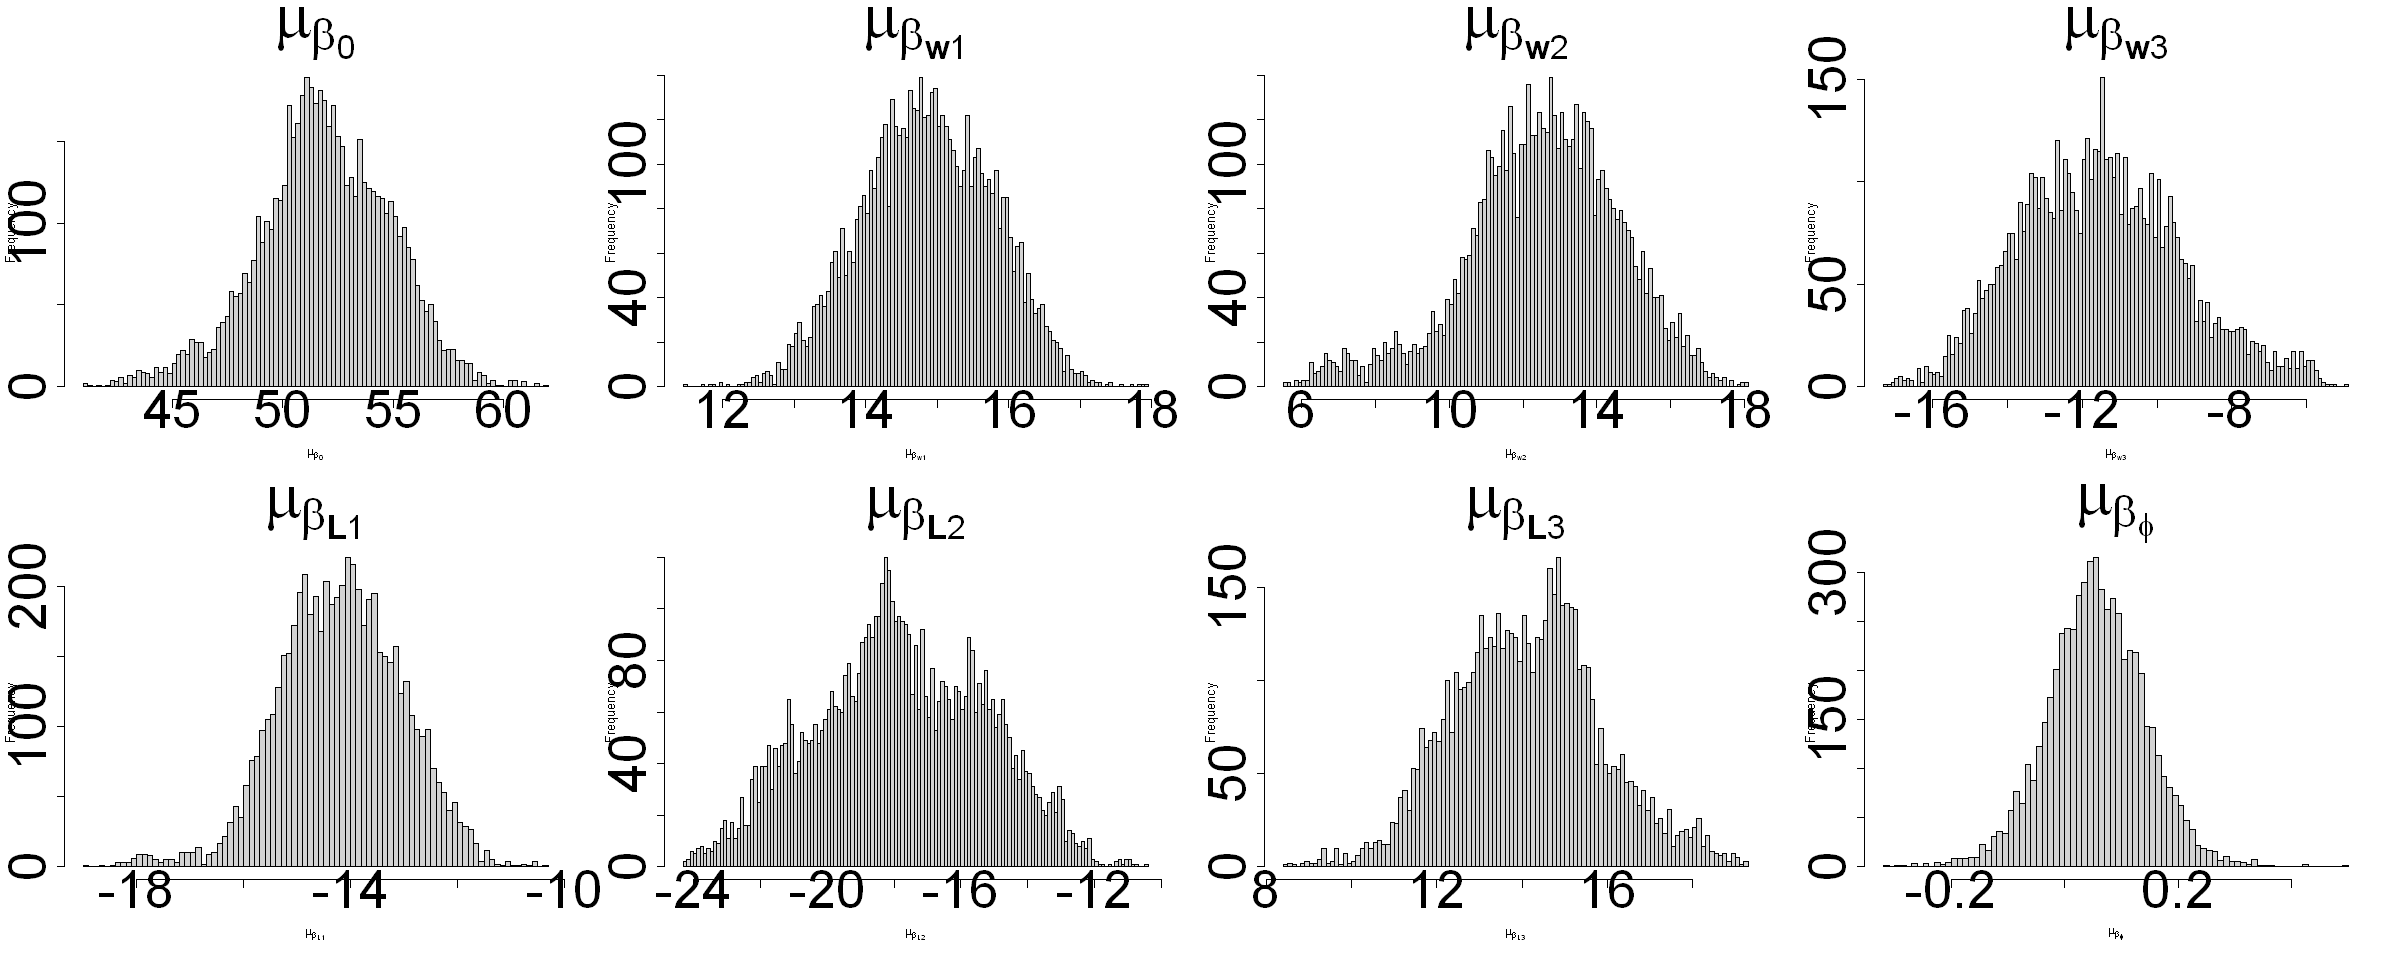

In [47]:
par(mfrow = c(2, 4), cex.main = 5, cex.axis=4)
options(repr.plot.width = 20, repr.plot.height = 8)  
hist(mcmc_m3[, "Mu[1]"], breaks = 100, main = expression(mu[bold(beta[0])]), xlab = expression(mu[bold(beta[0])]))
hist(mcmc_m3[, "Mu[2]"], breaks = 100, main = expression(mu[bold(beta[w1])]), xlab = expression(mu[bold(beta[w1])]))
hist(mcmc_m3[, "Mu[3]"], breaks = 100, main = expression(mu[bold(beta[w2])]), xlab = expression(mu[bold(beta[w2])]))
hist(mcmc_m3[, "Mu[4]"], breaks = 100, main = expression(mu[bold(beta[w3])]), xlab = expression(mu[bold(beta[w3])]))
hist(mcmc_m3[, "Mu[5]"], breaks = 100, main = expression(mu[bold(beta[L1])]), xlab = expression(mu[bold(beta[L1])]))
hist(mcmc_m3[, "Mu[6]"], breaks = 100, main = expression(mu[bold(beta[L2])]), xlab = expression(mu[bold(beta[L2])]))
hist(mcmc_m3[, "Mu[7]"], breaks = 100, main = expression(mu[bold(beta[L3])]), xlab = expression(mu[bold(beta[L3])]))
hist(mcmc_m3[, "Mu[8]"], breaks = 100, main = expression(mu[bold(beta[phi])]), xlab = expression(mu[bold(beta[phi])]))

### Fitted Model 3
$$y_{ij}= \begin{cases}
            \beta_{0i} + \beta_{w1i} \times |O|_{ij} + \beta_{w2i} \times PE_{ij} + \beta_{w3i} \times PE_{ij} \times |O|_{ij} + \beta_{i} \times y_{i(j-1)} \mbox{ when } O_{ij} > 0 \\
            \beta_{0i} + \beta_{L1i} \times |O|_{ij} + \beta_{L2i} \times PE_{ij} + \beta_{L3i} \times PE_{ij} \times |O|_{ij} + \beta_{i} \times y_{i(j-1)} \mbox{ when } O_{ij} \leq 0
        \end{cases}
$$




$$y_{ij}= \begin{cases}
            51.13 + 14.78 \times |O|_{ij} + 11.48 \times PE_{ij} -10.48 \times PE_{ij} \times |O|_{ij} + 0.06 \times y_{i(j-1)} \mbox{ when } O_{ij} > 0 \\
            51.13 - 14.02 \times |O|_{ij} -16.48 \times PE_{ij} + 13.21 \times PE_{ij} \times |O|_{ij} + 0.06 \times y_{i(j-1)} \mbox{ when } O_{ij} \leq 0
        \end{cases}
$$




### Model 4

In [ ]:
library(RWiener)
library(dplyr)
library(loo)
library(coda)
library(rjags)
load.module("wiener")
load.module("lecuyer")
#set.seed(1998)

setwd("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/Project 3 Data Analysis Tomi/Simulation 0329")
data <- read.table("m3 simulated data 0603.txt", header = TRUE, sep = ",")  # Adjust 'sep' based on your file's delimiter
#true.parameters <- read.table("M4 true parameters.txt", header = TRUE, sep = ",")  # Adjust 'sep' based on your file's delimiter
names(data)[names(data) == "subjno"] <- "Sub"
names(data)[names(data) == "Time"] <- "Trial"
names(data)[names(data) == "Y"] <- "Rating"
names(data)[names(data) == "Y_previous"] <- "Rating_previous"


#Source Kruschke's diagnostic MCMC functions
source("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/JAGS hierarchical model Johnson 2017/DBDA2E-utilities.R")

data$outcome.abs.win = ifelse(data$outcome.true>0, abs(data$outcome.true), 0)
data$outcome.abs.loss = ifelse(data$outcome.true<0, abs(data$outcome.true), 0)
data$prediction.error.win = ifelse(data$outcome.true>0, data$prob.loss, 0)
data$prediction.error.loss = ifelse(data$outcome.true<0, data$prob.win, 0)

data_model_m4=list(
  nTrials = length(data$Rating),
  nSubject = length(unique(data$Sub)),
  nVar = 4,
  subject = data$Sub,
  o.true = data$outcome.true,
  o.win = data$outcome.win,
  o.loss = data$outcome.loss,
  p.win = data$prob.win,
  p.loss = data$prob.loss,
  y = data$Rating,
  y_previous = data$Rating_previous,
  Rscal = 4 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 4))



model_String_m4 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * (o.true[t] - (2 * (1/(1+exp(-beta[subject[t],3]))) * o.win[t] * p.win[t] + (2 - 2 * (1/(1+exp(-beta[subject[t],3])))) * o.loss[t] * p.loss[t]))+
                    beta[subject[t],4] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * (o.true[t] - (2 * (1/(1+exp(-beta[subject[t],3]))) * o.win[t] * p.win[t] + (2 - 2 * (1/(1+exp(-beta[subject[t],3])))) * o.loss[t] * p.loss[t]))+
                    beta[subject[t],4] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m4, con = 'm4.txt')


#Create list of parameters to be monitored
parameters_m4 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m4 <- run.jags(method = "parallel",
                         model = 'm4.txt',
                         monitor = parameters_m4,
                         data = data_model_m4,
                         n.chains = 3,
                         adapt = 2000, #how long the samplers "tune"
                         burnin = 2000, #how long of a burn in
                         sample = 1000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         modules = c("wiener", "lecuyer"),
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m4, file = "jags_sample_m4.RData")

### Model 4*

In [ ]:
data_model_m4star=list(
  nTrials = length(data$Rating),
  nSubject = length(unique(data$Sub)),
  nVar = 3,
  subject = data$Sub,
  o.win = data$outcome.win,
  o.loss = data$outcome.loss,
  p.win = data$prob.win,
  p.loss = data$prob.loss,
  y = data$Rating,
  y_previous = data$Rating_previous,
  Rscal = 3 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 3))



model_String_m4star ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * (o.win[t] * p.win[t] + o.loss[t] * p.loss[t]) +
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * (o.win[t] * p.win[t] + o.loss[t] * p.loss[t]) +
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m4star, con = 'm4star.txt')


#Create list of parameters to be monitored
parameters_m4star <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m4star <- run.jags(method = "parallel",
                         model = 'm4star.txt',
                         monitor = parameters_m4star,
                         data = data_model_m4star,
                         n.chains = 3,
                         adapt = 2000, #how long the samplers "tune"
                         burnin = 2000, #how long of a burn in
                         sample = 1000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         modules = c("wiener", "lecuyer"),
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m4star, file = "jags_sample_m4star.RData")

### Model 5

In [ ]:
data_model_m5=list(
  nTrials = length(data$Rating),
  nSubject = length(unique(data$Sub)),
  nVar = 3,
  subject = data$Sub,
  o.true = data$outcome.true,
  pe = data$expectedness,
  y = data$Rating,
  y_previous = data$Rating_previous,
  Rscal = 3 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 3))



model_String_m5 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.true[t] * pe[t]+ 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.true[t]* pe[t] + 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m5, con = 'm5.txt')


#Create list of parameters to be monitored
parameters_m5 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m5 <- run.jags(method = "parallel",
                         model = 'm5.txt',
                         monitor = parameters_m5,
                         data = data_model_m5,
                         n.chains = 3,
                         adapt = 2000, #how long the samplers "tune"
                         burnin = 2000, #how long of a burn in
                         sample = 1000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         modules = c("wiener", "lecuyer"),
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m5, file = "jags_sample_m5.RData")